# CDE with tree boosting 05/23/2023

**TLDR**

- We implemented the (univariate) weak learner, the tree CDF with logistic regression at the internal nodes and flexible partition points. The tree is built via top-down greedy algorithm that minimizes the cross-entropy loss of the binary classification at the internal nodes.  

- We test the simplest case of such weak learner with data generated from such weak learner. 

- Next step: Implement the boosting algorithm for univariate data with the aforementioned weak learner.  

- Some remaining questions:  
  * Are partition points for which all samples are on the same side valid?
  * Regularization terms to encourage more balanced splits?  
  * In the current implementation, partition points with all samples on one side is allowed, and the branching probability (0 and 1) become independent of covariates. In addition to the log loss, a regularization term is added to the loss function to penalize such inbalance splits. 

**Test case**

Let $A = (0,1], A_l = (0, s], A_r = (s,1]$, where $s$ is the partition point.   

2000 samples $D=\{(Y_i, X_i)\}$ are generated from the following model:

$$X\stackrel{iid}{\sim}U(-4,4)$$
$$Y|X\stackrel{ind}{\sim}G_X$$
where $G_X$ is conditionally uniform on $A_l$ and $A_r$, and 
$$G_X(A_l|A) = \frac{1}{1 + \exp(\beta_1 X + \beta_0)}$$

We fit a stump with flexible partition points to this data, and compare the fitted $\beta_0,\beta_1$ and optimal partition points with the truth. 

In [12]:
from utils import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import bernoulli
from scipy.stats import uniform
from IPython.display import Audio
import matplotlib
import random

In [13]:
random.seed(123)

The parametrization of logistic regression in sklearn is
p = 1/(1+exp(bx + c))

We adopt Laplace penalty on the partition point $s$:

$$l_c(s) = \exp\{c|s-1/2|\}$$

Use grid search to find the optimal partition point $s$ that minimizes the sum of cross-entropy loss and $l_c(s)$. 

In the examples below, there are $n=2000$ samples, and the optimal $s$ is searched over 100 potential partition points. 

$c = \eta n(A)$

c = 0.1

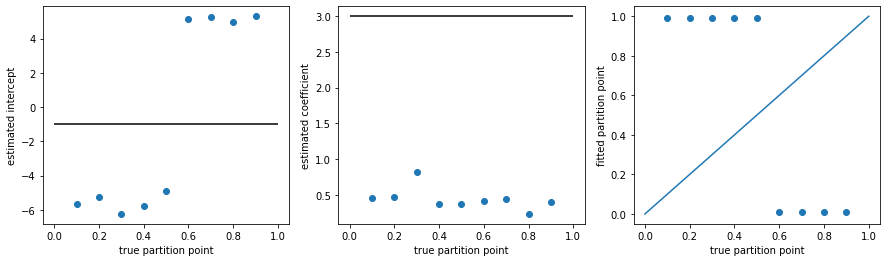

In [19]:
n = 2000
beta_true = [-1., 3.]
beta0, beta1 = [], []
partition = []
def f(x):
    return 0.1*abs(x-0.5)

for split_true in np.linspace(0.1, 0.9, 9):
    # split_true = 0.65
    nleft, nright = n/2, n/2
    x = uniform.rvs(loc = -4, scale = 8, size = n)
    p1 = 1./ (1. + np.exp((beta_true[1] * x + beta_true[0])))
    delta = np.array([bernoulli.rvs(p, size = 1)[0] for p in p1])
    y = np.array([uniform.rvs(loc = 0, scale = split_true) if d == 1 else uniform.rvs(loc = split_true, scale = 1 - split_true) for d in delta ])
    tree = TreeNode(left_bound=0, right_bound=1)
    tree.fit_logistic_greedy_regularization(residual = y, X = x, max_depth = 1, n_grid = 100, regularization = f)
    theta = []
    tree.getattr_bfs('theta', theta)
    beta0.append(theta[0][0])
    beta1.append(theta[0][1][0])
    split = []
    tree.getattr_bfs('split', split)
    partition.append([split_true, split[0]])

partition = np.array(partition).reshape((-1, 2))
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1);
plt.scatter(partition[:,0], beta0)
plt.hlines(y = beta_true[0], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated intercept');
plt.subplot(1, 3, 2);
plt.scatter(partition[:,0], beta1)
plt.hlines(y = beta_true[1], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated coefficient');
plt.subplot(1, 3, 3);
plt.scatter(partition[:,0], partition[:,1])
plt.xlabel('true partition point');
plt.ylabel('fitted partition point');
plt.plot([0,1], [0,1], "-");

c = 0.5

In [21]:
n = 2000
beta_true = [-1., 3.]
beta0, beta1 = [], []
partition = []
def f(x):
    return 0.5*abs(x-0.5)

for split_true in np.linspace(0.1, 0.9, 9):
    # split_true = 0.65
    nleft, nright = n/2, n/2
    x = uniform.rvs(loc = -4, scale = 8, size = n)
    p1 = 1./ (1. + np.exp((beta_true[1] * x + beta_true[0])))
    delta = np.array([bernoulli.rvs(p, size = 1)[0] for p in p1])
    y = np.array([uniform.rvs(loc = 0, scale = split_true) if d == 1 else uniform.rvs(loc = split_true, scale = 1 - split_true) for d in delta ])
#    plt.figure()
#    plt.scatter(x, y);
#    # plt.scatter(x, p1);
#    plt.xlabel('x');
#    plt.ylabel('y');
    tree = TreeNode(left_bound=0, right_bound=1)
    tree.fit_logistic_greedy_regularization(residual = y, X = x, max_depth = 1, n_grid = 100, regularization = f)
    theta = []
    tree.getattr_bfs('theta', theta)
    beta0.append(theta[0][0])
    beta1.append(theta[0][1][0])
    split = []
    tree.getattr_bfs('split', split)
    partition.append([split_true, split[0]])

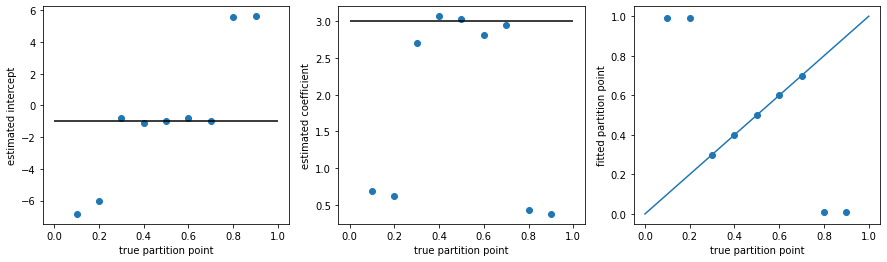

In [22]:
partition = np.array(partition).reshape((-1, 2))
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1);
plt.scatter(partition[:,0], beta0)
plt.hlines(y = beta_true[0], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated intercept');
plt.subplot(1, 3, 2);
plt.scatter(partition[:,0], beta1)
plt.hlines(y = beta_true[1], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated coefficient');
plt.subplot(1, 3, 3);
plt.scatter(partition[:,0], partition[:,1])
plt.xlabel('true partition point');
plt.ylabel('fitted partition point');
plt.plot([0,1], [0,1], "-");

c = 1

In [23]:
n = 2000
beta_true = [-1., 3.]
beta0, beta1 = [], []
partition = []
def f(x):
    return 1.*abs(x-0.5)

for split_true in np.linspace(0.1, 0.9, 9):
    # split_true = 0.65
    nleft, nright = n/2, n/2
    x = uniform.rvs(loc = -4, scale = 8, size = n)
    p1 = 1./ (1. + np.exp((beta_true[1] * x + beta_true[0])))
    delta = np.array([bernoulli.rvs(p, size = 1)[0] for p in p1])
    y = np.array([uniform.rvs(loc = 0, scale = split_true) if d == 1 else uniform.rvs(loc = split_true, scale = 1 - split_true) for d in delta ])
    tree = TreeNode(left_bound=0, right_bound=1)
    tree.fit_logistic_greedy_regularization(residual = y, X = x, max_depth = 1, n_grid = 100, regularization = f)
    theta = []
    tree.getattr_bfs('theta', theta)
    beta0.append(theta[0][0])
    beta1.append(theta[0][1][0])
    split = []
    tree.getattr_bfs('split', split)
    partition.append([split_true, split[0]])

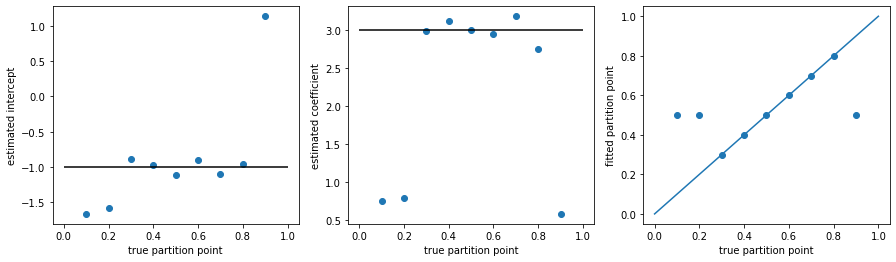

In [24]:
partition = np.array(partition).reshape((-1, 2))
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1);
plt.scatter(partition[:,0], beta0)
plt.hlines(y = beta_true[0], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated intercept');
plt.subplot(1, 3, 2);
plt.scatter(partition[:,0], beta1)
plt.hlines(y = beta_true[1], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated coefficient');
plt.subplot(1, 3, 3);
plt.scatter(partition[:,0], partition[:,1])
plt.xlabel('true partition point');
plt.ylabel('fitted partition point');
plt.plot([0,1], [0,1], "-");

c = 2

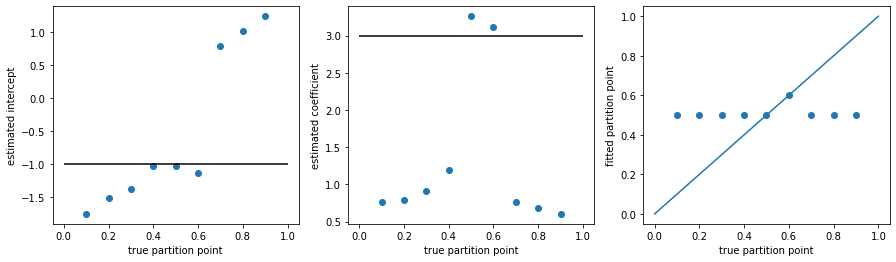

In [25]:
n = 2000
beta_true = [-1., 3.]
beta0, beta1 = [], []
partition = []
def f(x):
    return 2.*abs(x-0.5)

for split_true in np.linspace(0.1, 0.9, 9):
    # split_true = 0.65
    nleft, nright = n/2, n/2
    x = uniform.rvs(loc = -4, scale = 8, size = n)
    p1 = 1./ (1. + np.exp((beta_true[1] * x + beta_true[0])))
    delta = np.array([bernoulli.rvs(p, size = 1)[0] for p in p1])
    y = np.array([uniform.rvs(loc = 0, scale = split_true) if d == 1 else uniform.rvs(loc = split_true, scale = 1 - split_true) for d in delta ])
    tree = TreeNode(left_bound=0, right_bound=1)
    tree.fit_logistic_greedy_regularization(residual = y, X = x, max_depth = 1, n_grid = 100, regularization = f)
    theta = []
    tree.getattr_bfs('theta', theta)
    beta0.append(theta[0][0])
    beta1.append(theta[0][1][0])
    split = []
    tree.getattr_bfs('split', split)
    partition.append([split_true, split[0]])

partition = np.array(partition).reshape((-1, 2))
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1);
plt.scatter(partition[:,0], beta0)
plt.hlines(y = beta_true[0], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated intercept');
plt.subplot(1, 3, 2);
plt.scatter(partition[:,0], beta1)
plt.hlines(y = beta_true[1], xmin=0,xmax=1)
plt.xlabel('true partition point');
plt.ylabel('estimated coefficient');
plt.subplot(1, 3, 3);
plt.scatter(partition[:,0], partition[:,1])
plt.xlabel('true partition point');
plt.ylabel('fitted partition point');
plt.plot([0,1], [0,1], "-");

(Under construction) Functions for evaluating the density of a tree CDF and for generating Monte Carlo samples from a tree CDF

`TreeNode.MCsample_recursive()` and `TreeNode.log_density_univariate()`

In [5]:
root = TreeNode(left_bound=0,right_bound=1)
root.generate_full(root = root, depth = 3)
root.setattr_bfs_iterative('pleft', [0.6, 0.3, 0.8, None, None, None, None])
root.setattr_bfs_iterative('split', [0.2, 0.05, 0.7, None, None, None, None])
root.split2bound()

In [34]:
mc = np.array([root.MCsample_recursive() for i in range(n)])

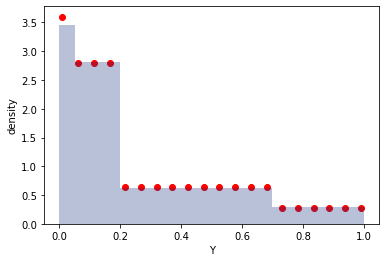

In [88]:
plt.hist(mc, bins=(0, 0.05,0.2,0.7, 1), density = True, color = (0.1, 0.2, 0.5, 0.3))
plt.scatter(np.linspace(0.01,0.99,20), [np.exp(root.log_density_univariate(x)) for x in np.linspace(0.01,0.99,20)], c="red")
plt.xlabel('Y');
plt.ylabel('density');
pass